In [1]:
%run A_load-images.ipynb

len(fnames)=684


Equalization of images with respect to a reference image, using a bit of code from https://github.com/laggui/timelapse-processing by Guillaume Lagrange :

In [2]:
verb = do_verb()

In [3]:
if verb: fnames = ttl.glob()

In [4]:
import cv2
import numpy as np


def histMatch(sourceImage, templateImage):
    """
    Matches the histogram of sourceImage to the templateImage in order to fix lightness/exposure
    of the sourceImage.
    """
    sourceImage = (sourceImage*255).astype(np.uint8)
    templateImage = (templateImage*255).astype(np.uint8)
    
    # Convert to LAB color space to work on lightness channel
    sourceLab = cv2.cvtColor(sourceImage, cv2.COLOR_RGB2LAB)
    sourceL, sourceA, sourceB = cv2.split(sourceLab)
    tempLab = cv2.cvtColor(templateImage, cv2.COLOR_RGB2LAB)
    tempL,_,_ = cv2.split(tempLab)

    # Get histogram of lightness channel for images
    sVal, binIdx, sCounts = np.unique(sourceL.ravel(), return_inverse=True, return_counts=True)
    scdf = np.cumsum(sCounts).astype(np.float64) # cumulative distribution function
    scdf /= scdf[-1] # normalize

    tVal, tCounts = np.unique(tempL.ravel(), return_counts=True)
    tcdf = np.cumsum(tCounts).astype(np.float64) # cumulative distribution function
    tcdf /= tcdf[-1] # normalize

    # Use linear interpolation of cdf to map new pixel values
    matched = np.rint(np.interp(scdf, tcdf, tVal)).astype(np.uint8)
    sourceL = matched[binIdx].reshape(sourceL.shape)
    
    matchedImage = cv2.merge([sourceL, sourceA, sourceB])
    matchedImage = cv2.cvtColor(matchedImage.astype(np.uint8), cv2.COLOR_LAB2RGB)
    #matchedImage = cv2.cvtColor(matchedImage, cv2.COLOR_LAB2RGB)

    return matchedImage


In [5]:
fname_reference = '../orchid/2021-02-14.22:10:07.jpg'
image_reference = ttl.process(fname_reference)

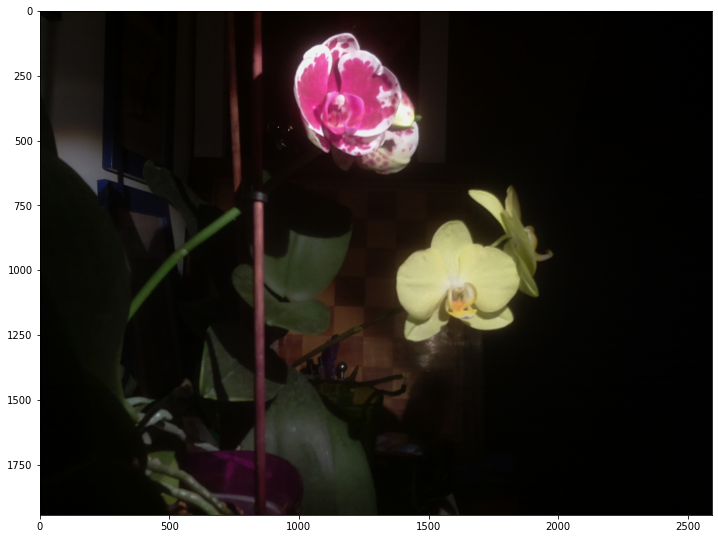

In [6]:
if verb:
    fig, ax = plt.subplots(figsize=ttl.figsize)
    ax.imshow(image_reference, vmin=0, vmax=255);

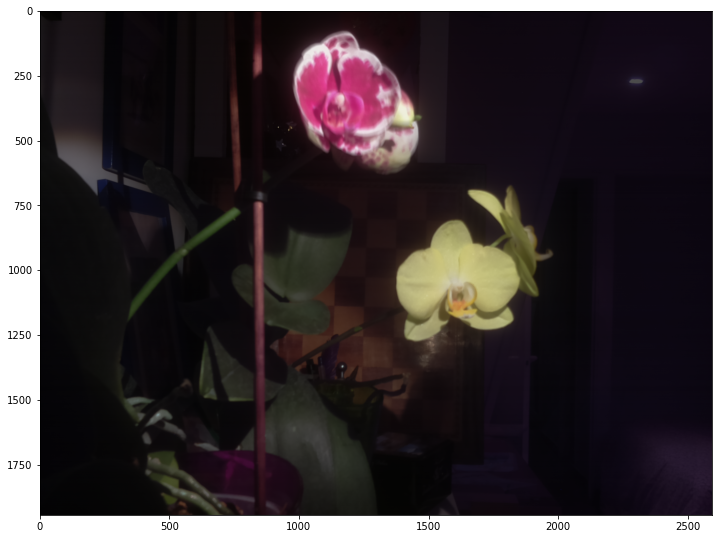

0.0020988677161005243 0.9690140845070422


In [7]:
count = 1
for fname in fnames:
    if '2021-02-14' in fname:
        image_reference += ttl.process(fname)
        count += 1
image_reference /= count
if verb:
    fig, ax = plt.subplots(figsize=ttl.figsize)
    ax.imshow(image_reference)
    plt.show();
    print(image_reference.min(), image_reference.max())

In [8]:
if verb: print(image_reference[0, 0])

[0.02640155 0.02314278 0.01220657]


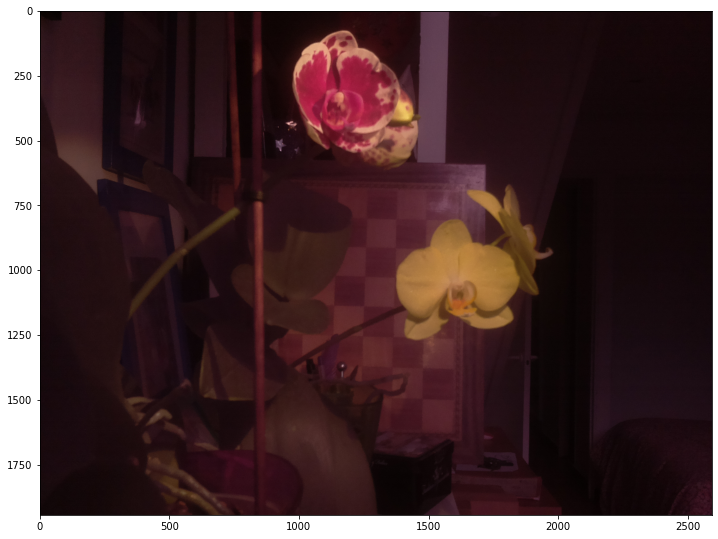

In [9]:
if verb:
    fname_new = '../orchid/2021-02-14.17:30:07.jpg'
    fig, ax = plt.subplots(figsize=ttl.figsize)
    ax.imshow(ttl.process(fname_new));

0 255


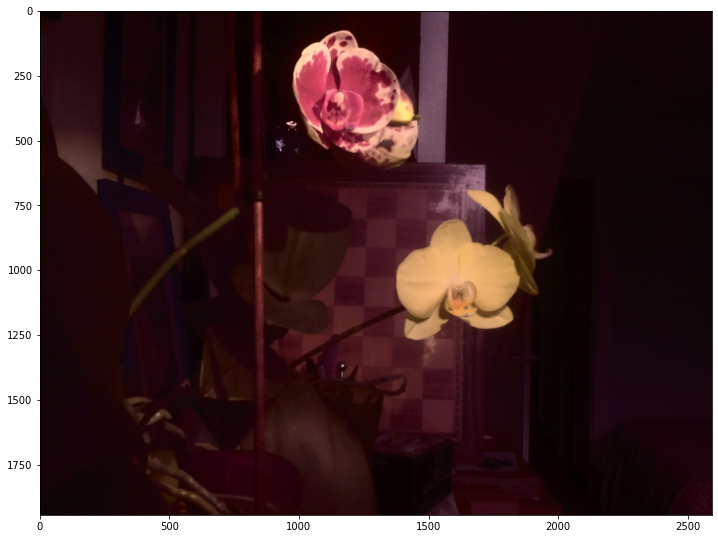

In [10]:
if verb:
    image_matched = histMatch(ttl.process(fname_new), image_reference)
    fig, ax = plt.subplots(figsize=ttl.figsize)
    ax.imshow(image_matched);

    print(image_matched.min(), image_matched.max())